<a href="https://colab.research.google.com/github/chelseadz/MultiagentDeepQ-learningForTransportNetworkDesignProblem/blob/main/multiagentProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#implementacion con dep q learning

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt


In [ ]:
 import pandas as pd

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Forzar uso CPU en caso de dispones GPU en el PC
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## 1. Environment

In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense
import itertools
import random
from copy import deepcopy

# Formato de los decimales en Pandas y la semilla del Random
pd.options.display.float_format = '{:,.2f}'.format
np.random.seed(5)

class Environment(object):
    def __init__(self, graph, n_routes, action_penalty=0, max_edges_per_node=5):
        self.graph = graph
        self.node_to_index = {node: idx for idx, node in enumerate(self.graph.nodes())}
        self.n_stops = self.graph.number_of_nodes()
        self.n_agents = n_routes
        self.state = [[] for _ in range(n_routes)]
        self.initial_positions = []

        self.final_state = False
        self.total_distance = 44066.81
        self.max_reward = 10000000
        self.min_difference = 15      # difference of stops between routes
        self.max_stops_untaken = n_routes
        self.connected_reward = False
        self.final_reward = False
        self.visited_nodes = set()

        for agent in range(self.n_agents):
            initial_node = np.random.choice(list(self.graph.nodes))
            self.state[agent].append(initial_node)
            self.initial_positions.append(initial_node)
            self.visited_nodes.add(initial_node)

        self.demand = np.ones((self.n_stops, self.n_stops), dtype=int)    #creamos demanda uniforme
        self.action_penalty = action_penalty

        self.total_reward = 0.0
        self.actions_done = []
        self.total_distance = 0.0

    def reset(self):
        self.total_reward = 0.0
        self.total_distance = 0.0
        self.state = [[] for _ in range(self.n_agents)]
        self.actions_done = []
        self.final_state = False
        self.initial_positions = []
        self.visited_nodes = set()

        for agent in range(self.n_agents):
            initial_node = np.random.choice(list(self.graph.nodes))
            self.state[agent].append(initial_node)
            self.initial_positions.append(initial_node)
            self.visited_nodes.add(initial_node)

        return self.state

    def get_state(self):
        return self.state

    def is_graph_connected(self):
        connected = []
        n = self.n_agents
        for actual_r in range(n):
            for next_r in range(actual_r + 1, n):
                set1 = set(self.get_state()[actual_r])
                set2 = set(self.get_state()[next_r])
                if len(list(set1 & set2)) != 0:
                    connected.append((actual_r, next_r))

        def dfs(grafo, inicio, destino, visitados):
            if inicio == destino:
                return True
            visitados.add(inicio)
            for tupla in grafo:
                if inicio in tupla:
                    vecino = tupla[0] if tupla[1] == inicio else tupla[1]
                    if vecino not in visitados:
                        if dfs(grafo, vecino, destino, visitados):
                            return True
            return False

        def existe_camino(grafo, inicio, destino):
            visitados = set()
            return dfs(grafo, inicio, destino, visitados)

        for start in range(n):
            for end in range(n):
                if not existe_camino(connected, start, end):
                    return False

        return True

    def all_stops_are_taken(self):
        nodes = set(self.graph.nodes())

        for route in self.get_state():
            taken = set(route)
            nodes = nodes - taken

        if len(nodes) > self.max_stops_untaken:
            return False
        else:
            return True

    def penalize_similar_routes(self, route):
        route = set(route)
        penalization = 0
        for other_route in self.get_state():
            intersection = len(list(route & set(other_route)))
            if intersection > self.min_difference:
                penalization += intersection
        return -penalization


    def reward_demand(self, route):
        new = route[-1]
        reward = 0

        if new not in set(route):
          for stop in route:
            reward += self.demand[stop][int(new)] * 10       # Bonifica por la demanda recogida
            reward += self.demand[int(new)][stop] * 10       # Bonifica por la demanda recogida
            self.demand[stop][int(new)] = 0        # Elimina la demanda una vez que un agente "recoge" la demanda

        return reward

    def is_final_state(self):
        if self.all_stops_are_taken():
            self.final_state = True
            return True
        else:
            self.final_state = False
            return False


    def get_rewards(self, s0, agent):
        route = s0[agent]

        if len(route) < 2:
            return -10  # Penalización por no moverse

        reward = 0

        if self.is_graph_connected() and not self.connected_reward:
            reward = reward + self.total_distance
            self.connected_reward = True    #Variable para verificar dar este reward una sola vez

        if self.is_final_state() and not self.final_reward:
            reward = reward + self.max_reward
            self.final_reward = True        #Variable para verificar dar este reward una sola vez


        last = route[-2]
        new = route[-1]
        edge_data = self.graph.get_edge_data(last, new)

        if edge_data is not None:
            reward -= edge_data['distancia'] * 0.10               # Penaliza por la distancia recorrida

            reward += self.reward_demand(route)

            reward += self.penalize_similar_routes(route)

        else:
            reward -= 100  # Penalización significativa por no encontrar una arista válida

        # Penalización adicional por repetición
        if new in route[-1]:   # Verifica si el nodo ya fue visitado, excluyendo el último añadido
            reward -= 500           # Penalización significativa por visitar una parada ya visitada

        # Penalización por estar cerca del punto de partida
        initial_position = self.initial_positions[agent]
        distance_from_start = nx.shortest_path_length(self.graph, source=initial_position, target=new, weight='distancia')
        reward -= (1 / (distance_from_start + 1)) * 100  # Penaliza más cuanto más cerca esté del punto de partida

        # Recompensa por visitar un nodo no explorado previamente
        if new not in self.visited_nodes:
            reward += 1000  # Recompensa por visitar un nodo nuevo
            self.visited_nodes.add(new)

        return reward


    def get_actions_for_stop(self, target_id):
        filtered_edges = list(self.graph.edges(target_id))
        actions_viable = []
        for edge in filtered_edges:
            other_number = edge[0] if edge[1] == target_id else edge[1]
            actions_viable.append(other_number)
        return actions_viable

    def actions(self, agent):
        stop = self.get_state()[agent][-1]
        viable_actions = self.get_actions_for_stop(stop)
        viable_actions = [action for action in viable_actions if action not in self.get_state()[agent]]
        if not viable_actions:
            viable_actions = self.get_actions_for_stop(stop)
        return viable_actions

    def step(self, action, agent, steps):
        self.apply_action(action, agent)
        self.actions_done.append([agent, action])
        reward = self.get_rewards(self.state, agent) - self.action_penalty
        self.total_reward += reward
        return self.state, reward, self.final_state

    def apply_action(self, action, agent):
        self.state[agent].append(action)
    """
    def print_path_episode(self):
        path = ['-' for _ in range(self.n_stops)]
        for index, step in enumerate(self.actions_done):
            path[self.node_to_index[step[1]]] = str(index + 1)

        print(pd.DataFrame(data=np.array([path]),
                           index=["Steps"],
                           columns=["Location {}".format(str(i)) for i in range(len(path))]))
    """

    # Funcion para devolver el estado final al final de la ejecución
    def get_final_state(self):
        return self.get_state()

<hr>


## <a name="M2">2.- Deep Q-Learner: Implementación</a>


* Recordemos el Pseudocódigo del Algoritmo:


<img src="./imgs/019_RL.png" style="width: 800px;"/>

In [ ]:
import os
import tensorflow as tf
import itertools
import random
import numpy as np
from tensorflow.keras.models import Sequential, clone_model
from tensorflow.keras.layers import Dense

# Configuraciones para suprimir los logs de TensorFlow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

class DeepQLearner(object):

    def __init__(self, environment, num_agents, max_memory=100, discount_factor=0.1, explotation_rate=0.95, max_steps=500):
        self.environment = environment
        self.num_agents = num_agents
        self.memory = list()
        self.max_memory = max_memory
        self.model = self.create_model()
        self.best_model = clone_model(self.model)
        self.best_model.set_weights(self.model.get_weights())
        self.best_reward = -np.inf
        self.discount_factor = discount_factor
        self.max_explotation_rate = explotation_rate
        self.explotation_rate = explotation_rate
        self.max_steps = max_steps

    @property
    def name(self):
        return 'Deep Q-Learner'

    def create_model(self):
        input_dim = self.environment.n_stops
        output_dim = self.environment.n_stops

        model = Sequential()
        model.add(Dense(32, activation='relu', input_dim=input_dim))
        model.add(Dense(output_dim, activation='linear'))
        model.compile(loss='mse', optimizer='adam')

        return model

    def get_next_actions(self, states):
        next_actions = []
        for agent in range(self.num_agents):
            state = states[agent]
            viable_actions = self.environment.actions(agent)
            if np.random.uniform() > self.explotation_rate:
                next_action = np.random.choice(viable_actions)
            else:
                state_array = self.state_to_array(state)
                qus = self.model.predict(np.array([state_array]), verbose=0)
                action_indices = np.argsort(qus[0])[::-1]
                next_action = None
                for idx in action_indices:
                    potential_action = list(self.environment.graph.nodes)[idx]
                    if potential_action in viable_actions:
                        next_action = potential_action
                        break
                if next_action is None:
                    next_action = np.random.choice(viable_actions)
            next_actions.append(next_action)
        return next_actions

    def update(self, states, actions, rewards, new_states, is_final_state, num_episode, num_steps):
        for i in range(self.num_agents):
            self.remember(state=states[i], action=actions[i], reward=rewards[i], new_state=new_states[i], is_final_state=is_final_state)
        if is_final_state or num_steps > self.max_steps:
            self.learn_batch()
            self.reset()

        if self.environment.total_reward > self.best_reward:
            self.best_reward = self.environment.total_reward
            self.best_model.set_weights(self.model.get_weights())

    def remember(self, state, action, reward, new_state, is_final_state):
        self.memory.append((state, action, reward, new_state, is_final_state))
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def learn_batch(self):
        batch_size = min(len(self.memory), 100)
        batch = random.sample(self.memory, batch_size)

        for state, action, reward, new_state, is_final_state in batch:
            state_array = self.state_to_array(state)
            new_state_array = self.state_to_array(new_state)

            q_values = self.model.predict(np.array([state_array]), verbose=0)
            idx_action = list(self.environment.graph.nodes).index(action)

            q_values[0][idx_action] = (reward + self.discount_factor * np.max(self.model.predict(np.array([new_state_array]), verbose=0)[0])
                                       if not is_final_state else reward)

            self.model.fit(np.array([state_array]), q_values, epochs=1, verbose=0)

        self.explotation_rate = self.max_explotation_rate - (self.max_explotation_rate / (len(self.memory) + 1))

    def reset(self):
        self.memory.clear()

    def state_to_array(self, states):
        state_array = np.zeros(self.environment.n_stops)
        for agent_state in states:
            for stop in agent_state:
                stop_index = self.environment.node_to_index[stop]
                state_array[stop_index] = 1
        return state_array

    def print_q_table(self):
        states = list(itertools.product(self.environment.graph.nodes, repeat=2))
        q_table = self.model.predict(np.array([self.state_to_array([state]) for state in states]), verbose=0)
        df = pd.DataFrame(data=q_table, columns=list(self.environment.graph.nodes))
        df.insert(0, 'Estado', ['{}->{}'.format(state[0], state[1]) for state in states])
        print(df.to_string(index=False))

    def print_best_values_states(self):
        states = list(itertools.product(self.environment.graph.nodes, repeat=2))
        q_table = self.model.predict(np.array([self.state_to_array([state]) for state in states]), verbose=0)

        best_values = np.array([[np.max(row) for row in q_table]])
        best_values = best_values.reshape((self.environment.n_stops, self.environment.n_stops))

        print(pd.DataFrame(data=best_values,
                           index=["x{}".format(str(i)) for i in range(len(best_values))],
                           columns=["y{}".format(str(i)) for i in range(len(best_values[0]))]))


<hr>


## <a name="M3">3.- Ejecución: Entorno - Agente</a>


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np
import csv
from copy import deepcopy

def run_agent(learner_class, num_agents, num_episodes=10, discount_factor=0.1, ratio_explotacion=0.95,
              max_steps=32, batch_size=10, verbose=False):
    """
    Método que ejecuta el proceso de aprendizaje del agente en un entorno por lotes
    :param learner_class:       Clase del Algoritmo de Aprendizaje
    :param num_agents:          Número de agentes
    :param num_episodes:        Número de veces que se ejecuta (o aprende) el agente en el entorno
    :param discount_factor:     Factor de descuento (0=Estrategia a corto plazo, 1=Estrategia a largo plazo)
    :param ratio_explotacion:   Ratio de explotación
    :param max_steps:           Número máximo de pasos a ejecutar en un episodio
    :param batch_size:          Número de episodios por lote
    :param verbose:             Boolean, si queremos o no imprimir por pantalla información del proceso
    :return:                    Estado final de los agentes
    """

    # Cargar el grafo desde el archivo .gexf
    graph = nx.read_gexf('/content/grafo_paradas2.gexf')

    # Instanciamos el entorno
    environment = Environment(graph=graph, n_routes=num_agents, max_edges_per_node=8)  # Limitamos a 8 aristas por nodo

    # Instanciamos el método de aprendizaje
    learner = learner_class(environment=environment,
                            num_agents=num_agents,
                            max_memory=100,
                            discount_factor=discount_factor,
                            explotation_rate=ratio_explotacion,
                            max_steps=max_steps)

    last_episode = None

    with open('out.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        for n_episode in range(0, num_episodes, batch_size):
            for b in range(batch_size):
                episode_idx = n_episode + b
                if episode_idx >= num_episodes:
                    break

                state = environment.reset()
                is_final_state = False
                num_steps_episode = 0
                while not is_final_state and num_steps_episode < max_steps:
                    old_state = deepcopy(state)
                    next_actions = learner.get_next_actions(states=old_state)  # Acciones a realizar; explotando o explorando
                    rewards = []
                    new_states = []
                    for agent in range(num_agents):
                        new_state, reward, is_final_state = environment.step(next_actions[agent], agent, num_steps_episode + 1)
                        rewards.append(reward)
                        new_states.append(new_state)
                    learner.update(states=deepcopy(old_state),
                                  actions=next_actions,
                                  rewards=rewards,
                                  new_states=deepcopy(new_states),
                                  is_final_state=is_final_state,
                                  num_episode=episode_idx + 1,
                                  num_steps=num_steps_episode)
                    state = new_states
                    num_steps_episode += 1  # Sumamos un paso al episodio

                last_episode = {'episode': environment,
                                'learner': learner}

                actual_state = environment.get_final_state()
                writer.writerow([episode_idx + 1, environment.total_reward])
                writer.writerows(actual_state)

                # Imprimimos la información de los episodios
                if verbose:
                    print('EPISODIO {} - Número de acciones: {} - Recompensas: {}'
                          .format(episode_idx + 1, num_steps_episode, environment.total_reward))

            # Aprender en lotes después de cada lote de episodios
            learner.learn_batch()

    final_state = environment.get_final_state()
    if verbose:
        print('ESTADO FINAL:')
        for i, agent_state in enumerate(final_state):
            print(f'Agente {i + 1}: {agent_state}')

    return final_state

def print_process_info(last_episode, print_q_table=True, print_best_values_states=True,
                       print_best_actions_states=True, print_steps=True, print_path=True):
    """
    Método que imprime por pantalla los resultados de la ejecución
    """
    if print_q_table:
        print('\nQ_TABLE:')
        last_episode['learner'].print_q_table()

    if print_best_values_states:
        print('\nBEST Q_TABLE VALUES:')
        last_episode['learner'].print_best_values_states()

    if print_best_actions_states:
        print('\nBEST ACTIONS:')
        last_episode['learner'].print_best_actions_states()

    if print_steps:
        print('\nPasos: \n   {}'.format(last_episode['episode'].actions_done))

    if print_path:
        print('\nPATH:')
        last_episode['episode'].print_path_episode()

In [ ]:
# Verificar si TensorFlow está utilizando la GPU
print("GPUs disponibles: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.debugging.set_log_device_placement(False)  # Para verificar qué dispositivo se está utilizando

GPUs disponibles:  0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Ejecutar el agente
final_state = run_agent(learner_class=DeepQLearner,
                        num_agents=2,
                        num_episodes=1,
                        discount_factor=0.1,
                        ratio_explotacion=0.95,
                        max_steps=100,
                        batch_size=5,
                        verbose=True)

EPISODIO 1 - Número de acciones: 100 - Recompensas: 77385.53787240764
ESTADO FINAL:
Agente 1: ['1725', '1712', '1781', '1726', '1707', '1713', '1774', '1703', '1740', '1748', '1814', '1837', '1845', '1794', '1694', '1687', '1681', '1608', '1676', '1690', '1666', '1525', '1519', '1443', '1406', '1331', '1372', '1339', '1290', '1207', '1209', '1263', '1175', '1177', '1186', '1148', '1072', '1075', '1199', '1284', '1293', '1322', '1355', '1381', '1366', '1458', '1450', '1452', '1511', '1437', '1353', '1289', '1305', '1363', '1451', '1434', '1440', '1490', '1545', '1682', '1597', '1571', '1598', '1510', '1430', '1491', '1484', '1448', '1506', '1576', '1595', '1577', '1568', '1582', '1592', '1526', '1620', '1531', '1501', '1631', '1662', '1573', '1572', '1652', '1634', '1622', '1697', '1795', '1817', '1807', '1788', '1833', '1896', '1951', '2012', '1935', '1888', '1894', '1842', '1806', '1802']
Agente 2: ['1424', '1397', '1438', '1409', '1457', '1416', '1379', '1302', '1218', '1256', '1277'

In [ ]:
import shutil

# Ruta del archivo en el entorno de Colab
archivo_local = 'out.csv'

# Ruta del archivo en Google Drive
ruta_en_drive = '/content/drive/My Drive/Colab Notebooks/out.csv'

# Copiar el archivo a Google Drive
shutil.copy(archivo_local, ruta_en_drive)

<ipython-input-7-a0a5252d2156>:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(final_states))


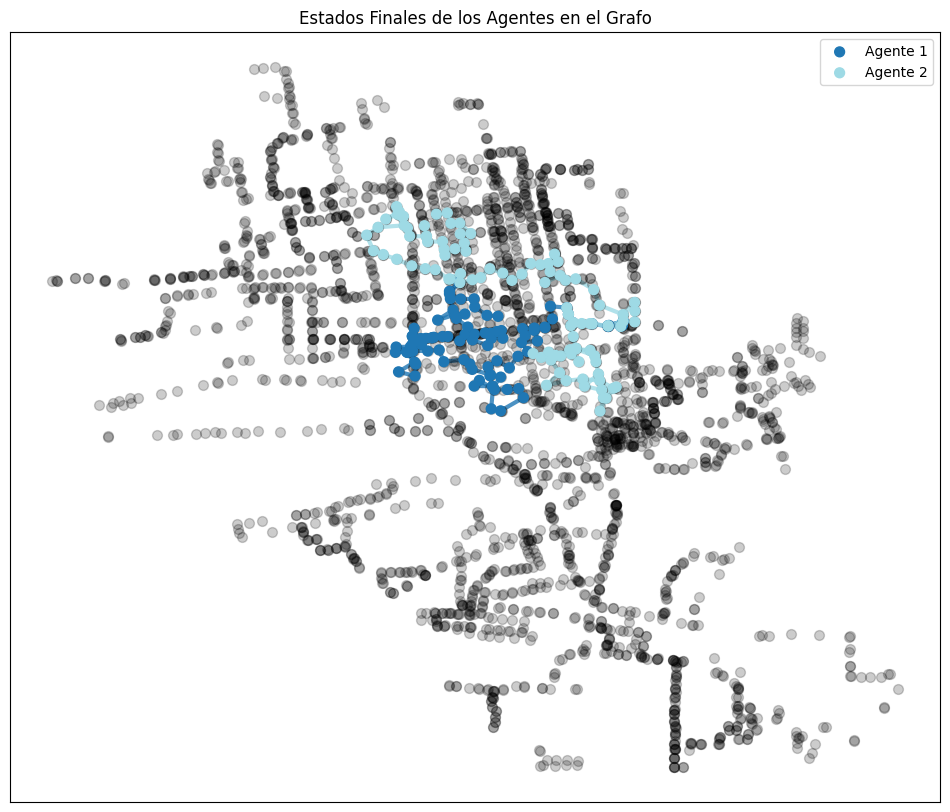

In [ ]:
import matplotlib.pyplot as plt

# Plotear el estado final
def plot_final_states(graph, final_states):
    pos = {node: (graph.nodes[node]['Longitud'], graph.nodes[node]['Latitude']) for node in graph.nodes()}
    plt.figure(figsize=(12, 10))

    # Dibujar todos los nodos y aristas del grafo en el fondo
    nx.draw_networkx_nodes(graph, pos, node_color='black', node_size=50, alpha=0.2)
    # Colores para los agentes
    colors = plt.cm.get_cmap('tab20', len(final_states))

    # Plotear los estados finales de cada agente con colores diferentes
    for i, state in enumerate(final_states):
        node_list = state
        edges = [(node_list[j], node_list[j+1]) for j in range(len(node_list) - 1)]
        node_colors = [colors(i) for _ in range(len(node_list))]

        # Dibujar nodos y aristas del grafo
        nx.draw_networkx_edges(graph, pos, edgelist=edges, edge_color=colors(i), width=3.0, alpha=0.8)
        nx.draw_networkx_nodes(graph, pos, nodelist=node_list, node_color=node_colors, node_size=50, alpha=1, label=f'Agente {i+1}')

    #nx.draw_networkx_nodes(graph,pos=nx.spring_layout(graph),node_color="black",node_size=50,nodelist=graph.nodes())
    plt.legend()
    plt.title("Estados Finales de los Agentes en el Grafo")
    plt.show()

# Cargar el grafo
graph = nx.read_gexf('/content/grafo_paradas2.gexf')
# Plotear el estado final
plot_final_states(graph, final_state)




# Funciones para el grafo


In [ ]:
import networkx as nx
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import math

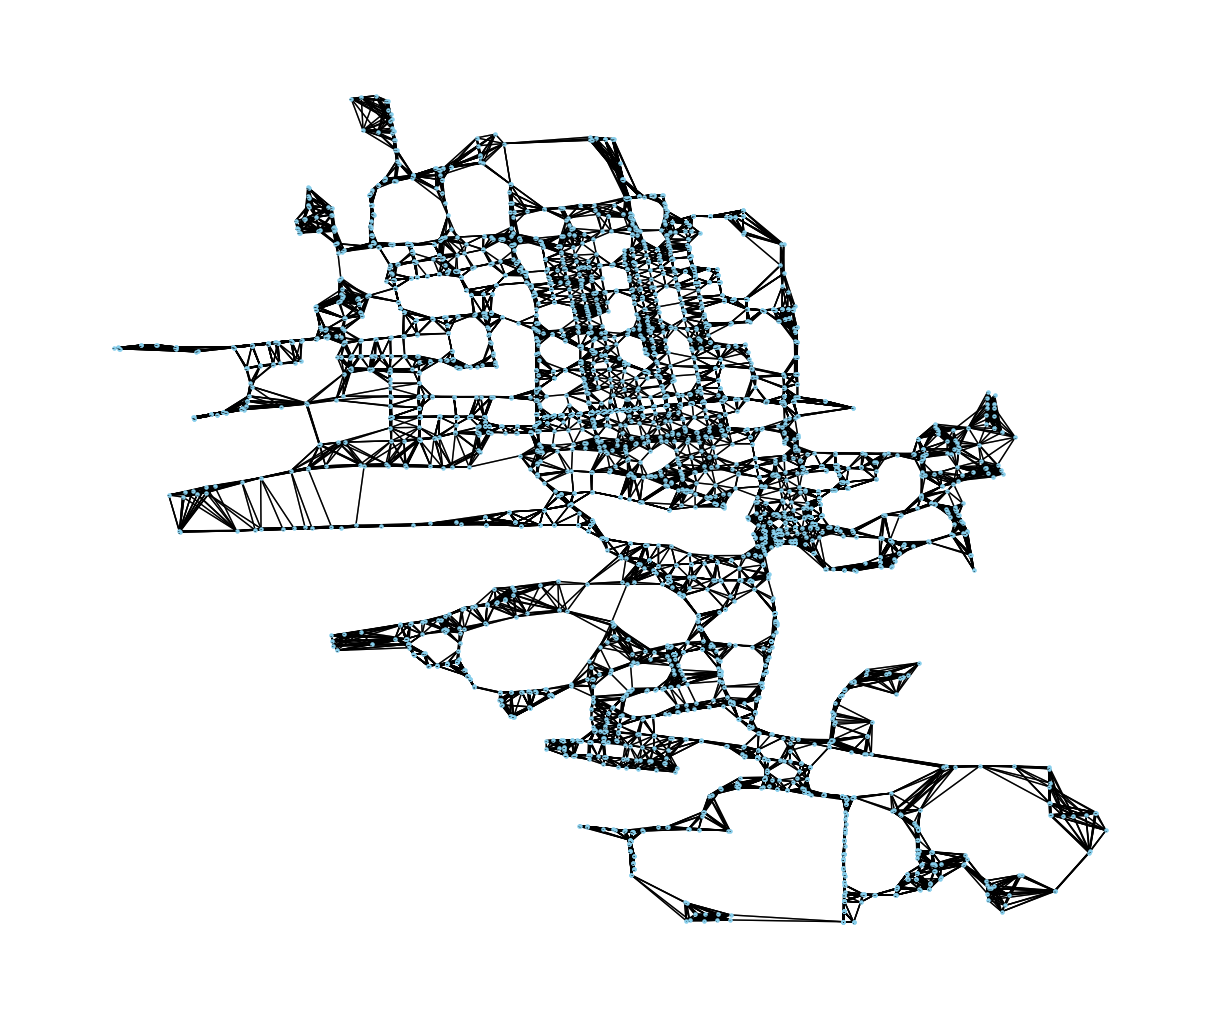

In [ ]:
file_path = '/content/grafo_paradas2.gexf'
graph = nx.read_gexf(file_path)
"Se visualiza el grafo"
#Se dibuja el grafo basado en Longitud y Latitud
pos = {node: (graph.nodes[node]['Longitud'], graph.nodes[node]['Latitude']) for node in graph.nodes()}

plt.figure(figsize=(12, 10))  # Sirve para hacer más grande la figura

nx.draw(graph, pos, with_labels=True, node_size=5, node_color='skyblue', font_size=0.2)

# Se pone las aristas , el chuqui
nx.draw_networkx_edges(graph, pos, width=1.0, alpha=0.5)

plt.show()

In [ ]:
# Cargar el grafo desde un archivo .gexf
G = nx.read_gexf('/content/grafo_paradas2.gexf')

In [ ]:
#  nodos del grafo
total = 0
for edge in G.edges('2'):
    print(int(edge[1]))

0
1
16
17
18
19
24
25


TypeError: Axes.annotate() missing 1 required positional argument: 'text'

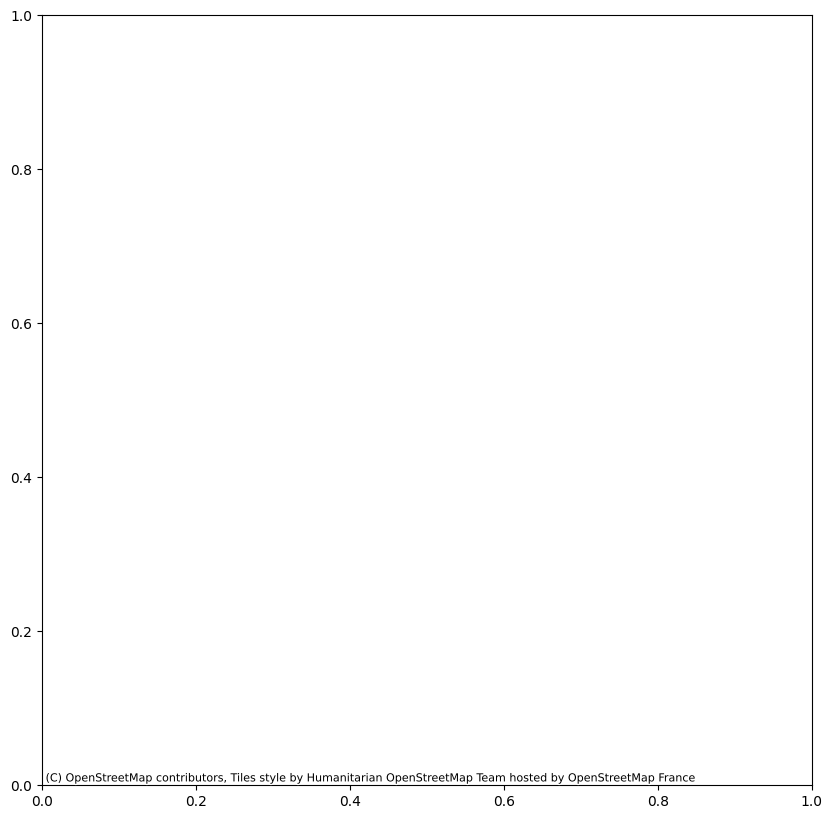

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
from shapely.geometry import LineString, box

# Cargar el grafo
file_path = '/content/grafo_paradas2.gexf'
graph = nx.read_gexf(file_path)

# Crear un GeoDataFrame de los nodos con sus coordenadas
nodes = list(graph.nodes(data=True))
node_positions = {node: (data['Longitud'], data['Latitude']) for node, data in nodes}
gdf_nodes = gpd.GeoDataFrame(
    {'id': list(node_positions.keys())},
    geometry=gpd.points_from_xy(
        [pos[0] for pos in node_positions.values()],
        [pos[1] for pos in node_positions.values()]
    ),
    crs="EPSG:4326"  # Sistema de referencia de coordenadas WGS84
)

# Crear un GeoDataFrame de las aristas con sus coordenadas
edges = list(graph.edges(data=True))
gdf_edges = gpd.GeoDataFrame(
    {'start': [edge[0] for edge in edges], 'end': [edge[1] for edge in edges]},
    geometry=[
        LineString([node_positions[edge[0]], node_positions[edge[1]]])
        for edge in edges
    ],
    crs="EPSG:4326"
)

# Convertir a la proyección adecuada para contextily (Web Mercator)
gdf_nodes = gdf_nodes.to_crs(epsg=3857)
gdf_edges = gdf_edges.to_crs(epsg=3857)

# Definir las coordenadas límites del área específica
lat_min, lat_max = 29.061, 29.151
lon_min, lon_max = -111.022, -110.902

# Crear un cuadro delimitador (bounding box) en Web Mercator
bbox = box(lon_min, lat_min, lon_max, lat_max)
bbox_gdf = gpd.GeoDataFrame(geometry=[bbox], crs="EPSG:4326").to_crs(epsg=3857)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 10))

# Añadir el mapa base
ctx.add_basemap(ax, crs=gdf_nodes.crs.to_string(), zoom=14)

# Dibujar los nodos y las aristas
gdf_edges.plot(ax=ax, color='blue', alpha=0.5, linewidth=1)
gdf_nodes.plot(ax=ax, color='red', markersize=5)

# Añadir etiquetas a los nodos
for idx, row in gdf_nodes.iterrows():
    ax.annotate(s=row['id'], xy=(row.geometry.x, row.geometry.y), fontsize=5)

# Ajustar la vista a las coordenadas específicas
ax.set_xlim(bbox_gdf.total_bounds[0], bbox_gdf.total_bounds[2])
ax.set_ylim(bbox_gdf.total_bounds[1], bbox_gdf.total_bounds[3])

# Mostrar la figura
plt.show()


In [ ]:
pip install contextily geopandas
# Definir las coordenadas límites del área específica
lat_min, lat_max = 28.9730, 29.1971
lon_min, lon_max = -111.1277, -110.8874

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 25.5 MB/s eta 0:00:00


In [ ]:
pip install shapely
